# Calibrated Satellite Altimeter Observations

This notebook shows examples to load and analyse significant wave height satellite altimeter observations from the dataset of  [Ribal and Young (2019)](https://www.nature.com/articles/s41597-019-0083-9]). We will explore the following key points:

1. Inspect and interact with the data using the [Datamesh python client](https://oceanum-python.readthedocs.io/en/latest/)
2. Query and visualise global satellite passes over a 24h period
3. Load and analyse altimeter data within a specific area
4. Use the data to validate one of Oceanum's hindcast datasets

In [1]:
import os
import geopandas
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs
from cartopy import feature as cfeature
from wavespectra import read_dataset
from tqdm import tqdm
from datetime import datetime, timedelta

from oceanum.datamesh import Connector

import warnings
warnings.filterwarnings("ignore")

## 1. Search and inspect data

### 1.1. Datamesh connector 
Put your datamesh token in the Jupyterlab settings, or as the `token` argument in the constructor below

In [2]:
datamesh = Connector(token=None)

### 1.2. Search for the datasource

Search for the IMOS altimetry observations in Datamesh using the [get_catalog](https://oceanum-python.readthedocs.io/en/latest/classes/datamesh/oceanum.datamesh.Connector.html#oceanum.datamesh.Connector.get_catalog) method which returns a catalog with all datasources matching the searching criteria

In [3]:
cat = datamesh.get_catalog("imos")
list(cat)

[
         IMOS calibrate altimetry waves and wind [imos_wave_wind]
             Extent: (0.0, -83.0, 360.0, 88.0)
             Timerange: 1991-08-01 00:00:00+00:00 to 2024-01-04 00:00:00+00:00
         ]

### 1.3. Inspect the datasource

Each entry in the catalog is a Datamesh [Datasource](https://oceanum-python.readthedocs.io/en/latest/classes/datamesh/oceanum.datamesh.Datasource.html#oceanum.datamesh.Datasource) object which holds a number of attributes defining the data such as `variables`, `coordinates`, `schema`, `tstart`, `tend` and others. Datasource instances can also be directly created from the datasource ID using the `get_datasource` method:

In [4]:
ds = datamesh.get_datasource("imos_wave_wind")

In [5]:
ds.description

'A calibrated multi-platform dataset of wave and wind parameters estimated from 13 altimeters.'

In [6]:
ds.tstart

datetime.datetime(1991, 8, 1, 0, 0, tzinfo=TzInfo(UTC))

In [7]:
ds.tend

datetime.datetime(2024, 1, 4, 0, 0, tzinfo=TzInfo(UTC))

In [8]:
list(ds.variables.keys())

['id',
 'time',
 'uwnd',
 'vwnd',
 'wspd',
 'swh_c',
 'sig0_c',
 'swh_ku',
 'sig0_ku',
 'geometry',
 'latitude',
 'platform',
 'wspd_cal',
 'bot_depth',
 'longitude',
 'dist2coast',
 'swh_ku_cal',
 'swh_c_num_obs',
 'swh_c_std_dev',
 'sig0_c_num_obs',
 'sig0_c_std_dev',
 'swh_ku_num_obs',
 'swh_ku_std_dev',
 'sig0_ku_num_obs',
 'sig0_ku_std_dev',
 'mean_wave_period',
 'swh_c_quality_control',
 'sig0_c_quality_control',
 'swh_ku_quality_control',
 'sig0_ku_quality_control']

## 2. Analyse globally

Load and analyse satellite altimeter passes globally within a 24h period

### 2.1. Load the Hs altimeter observations

Select all the available data from 01 Jan 2024

In [9]:
t0 = datetime(2024, 1, 1, 0, 0, 0)
t1 = datetime(2024, 1, 1, 23, 59, 59)

query = dict(
    datasource="imos_wave_wind",
    variables=["swh_ku_cal", "swh_ku_quality_control", "platform"],
    timefilter={"type": "range", "times": [t0, t1]},
)
df = datamesh.query(query)
df.tail()

time  longitude  latitude  swh_ku_cal  \
326030 2024-01-01 13:04:11.999997  358.71838  66.02671       4.415   
326031 2024-01-01 13:04:13.000002  358.84430  66.02158       4.297   
326032 2024-01-01 13:04:13.999996  358.97018  66.01635       4.176   
326033 2024-01-01 13:04:15.000001  359.09598  66.01100       4.341   
326034 2024-01-01 13:04:15.999996  359.22177  66.00555       4.073   

        swh_ku_quality_control          platform                    geometry  
326030                     1.0  SENTINEL-6A       POINT (358.71838 66.02671)  
326031                     1.0  SENTINEL-6A        POINT (358.8443 66.02158)  
326032                     1.0  SENTINEL-6A       POINT (358.97018 66.01635)  
326033                     1.0  SENTINEL-6A         POINT (359.09598 66.011)  
326034                     1.0  SENTINEL-6A       POINT (359.22177 66.00555)

### 2.2. Filter the data

Keep only the "good" data (see https://www.nature.com/articles/s41597-019-0083-9)

In [10]:
df = df.loc[df.swh_ku_quality_control == 1]
df.shape

(257719, 7)

### 2.1. Plot satellite passes scatter

Scatter map of the passes with colors showing the Significant wave height

In [11]:
def plot_passes(df, vmin, vmax, title):
    projection = ccrs.Mollweide(central_longitude=180)
    transform = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(18, 7.5), subplot_kw=dict(projection=projection))
    ax.set_global()
    p = ax.scatter(
        x=df.longitude,
        y=df.latitude,
        c=df.swh_ku_cal,
        s=5,
        cmap="turbo",
        vmin=vmin,
        vmax=vmax,
        alpha=0.5,
        transform=transform,
    )
    cbar = plt.colorbar(p, label="Hs (m)", shrink=0.75)
    ax.set_title(title)
    ax.add_feature(cfeature.LAND, facecolor="0.7", edgecolor="0.3", linewidth=0.5)
    gl = ax.gridlines(draw_labels=False, color="0.8", alpha=0.5)
    return fig, ax

#### All data

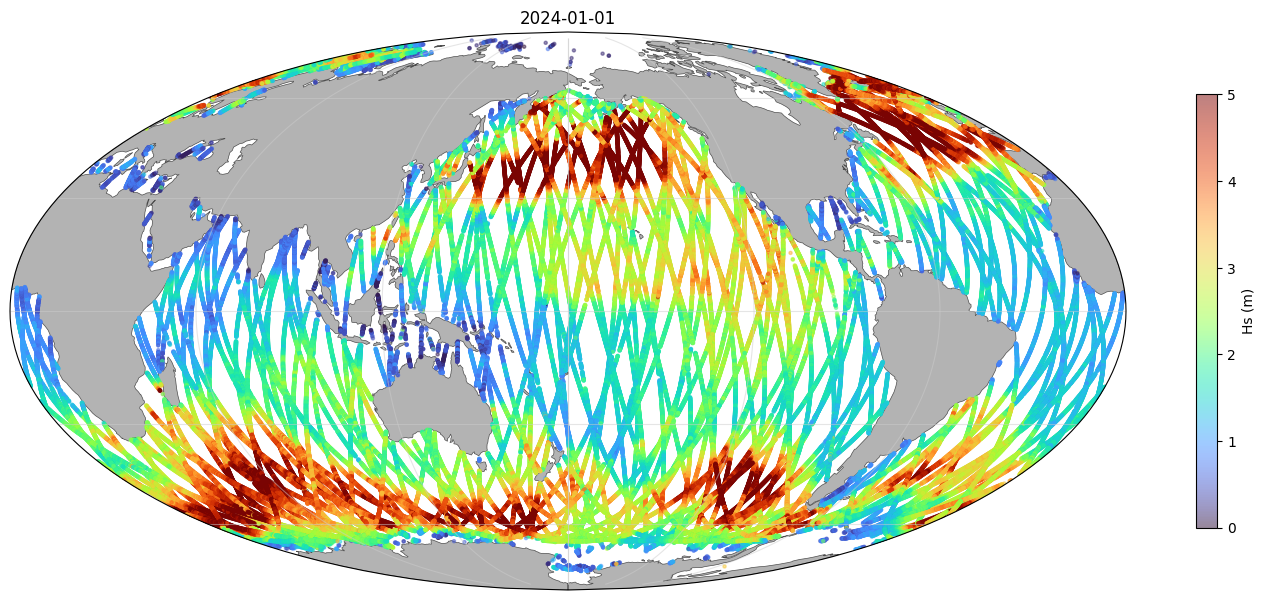

In [12]:
fig, ax = plot_passes(df, vmin=0, vmax=5, title=f"{t0:%Y-%m-%d}")

#### Each satellite platform

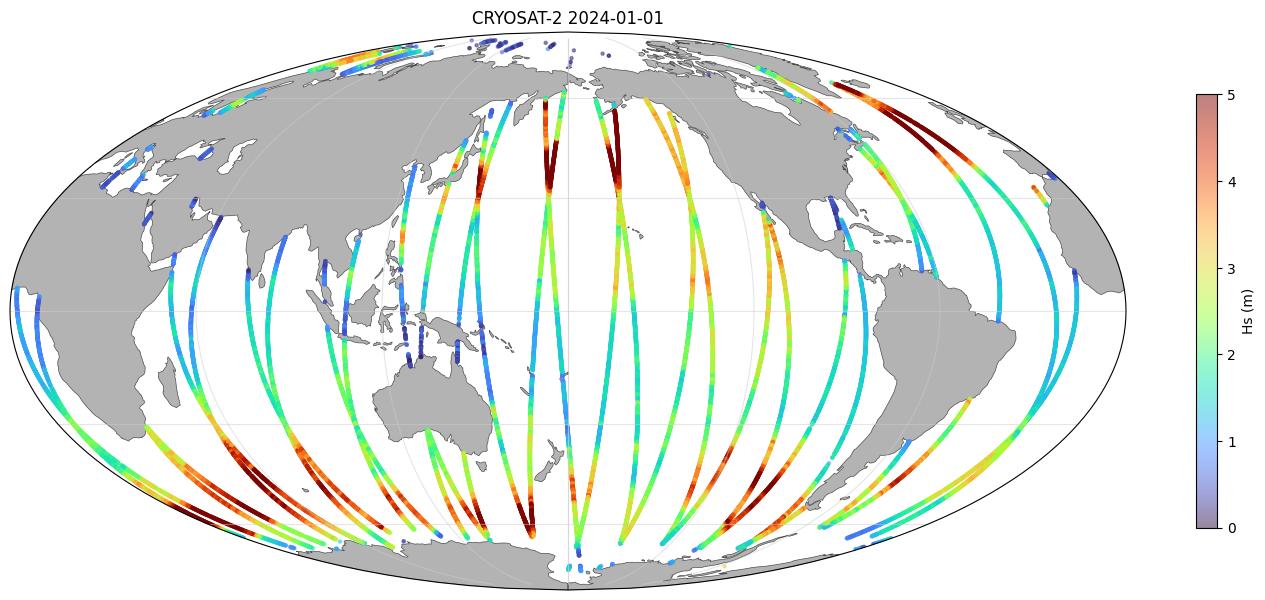

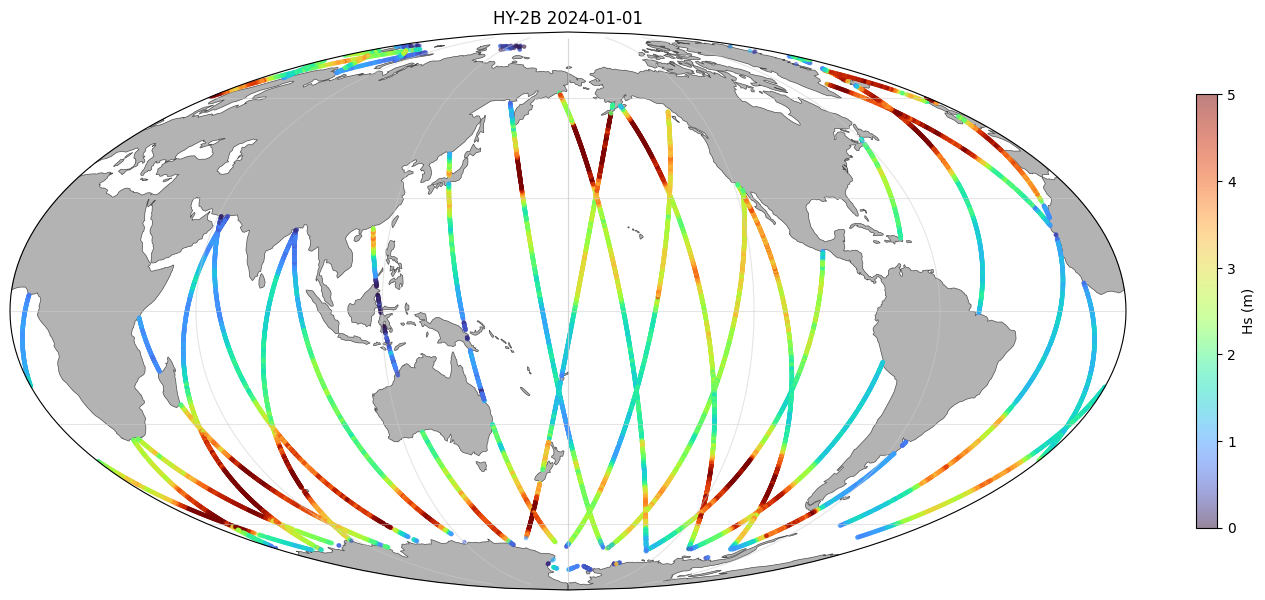

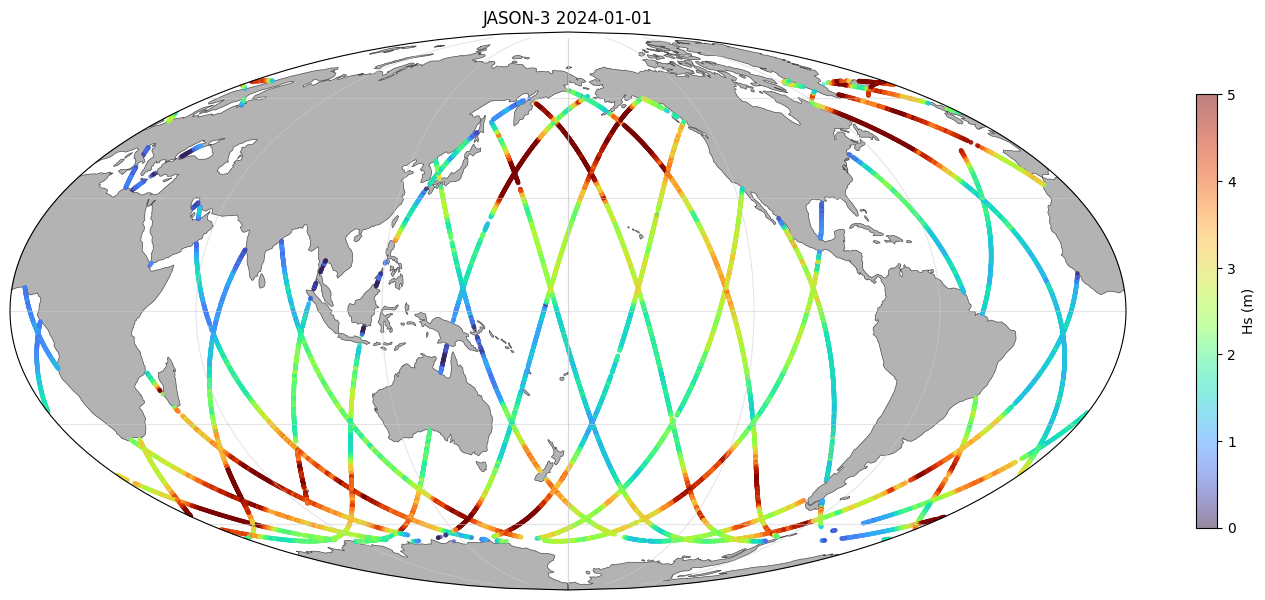

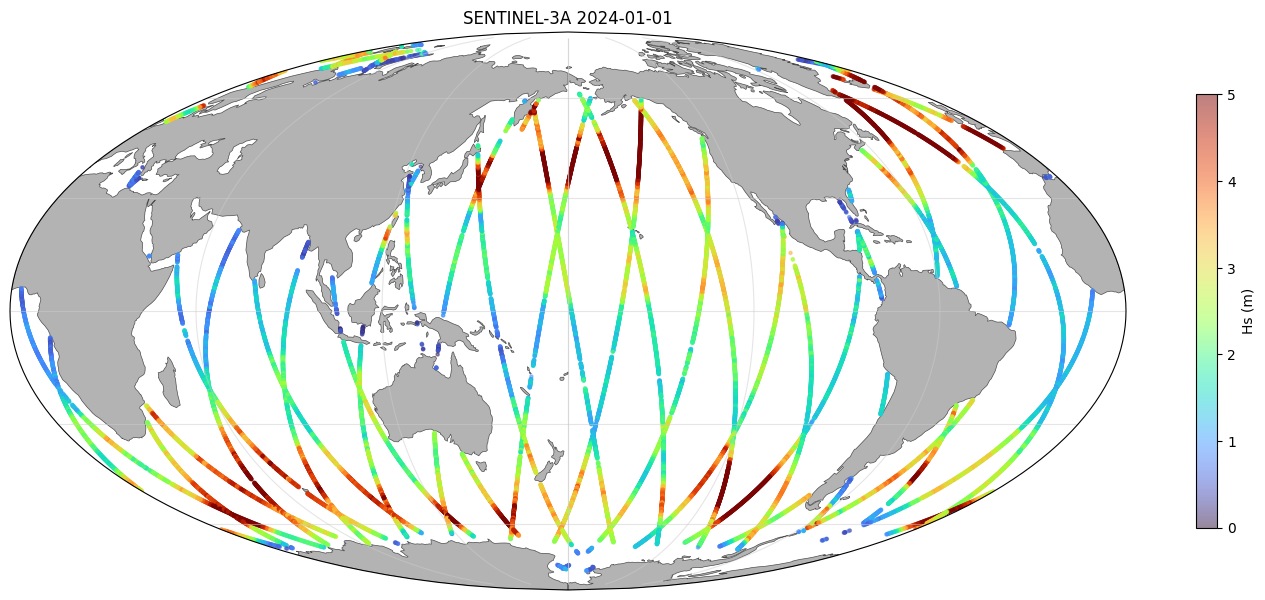

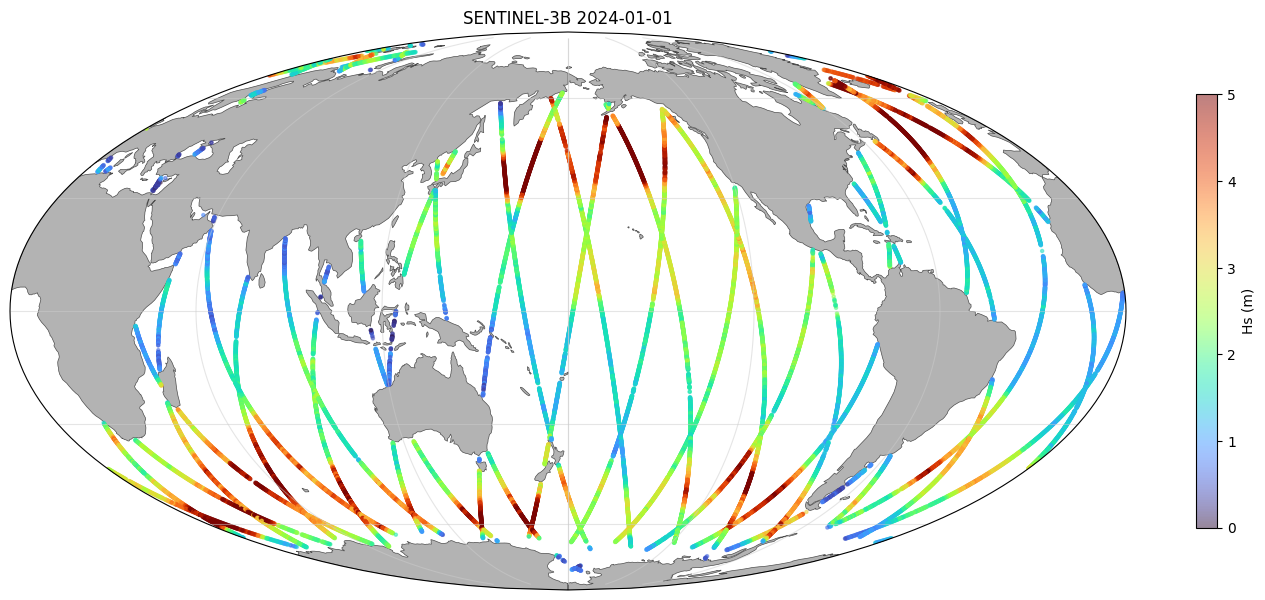

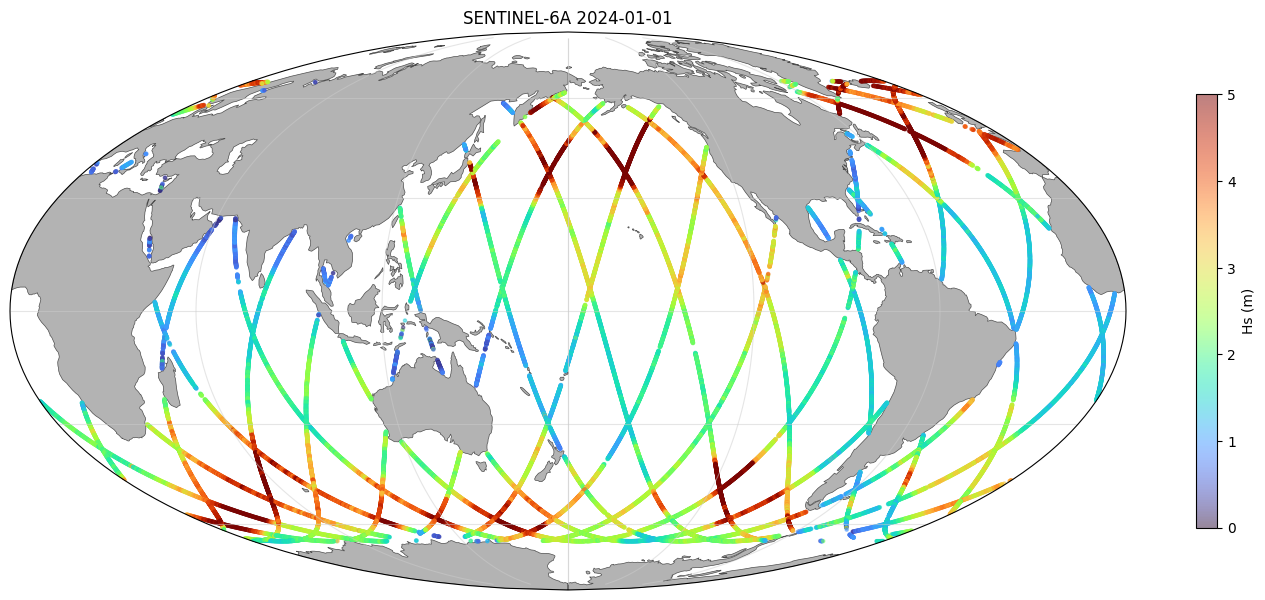

In [13]:
platforms = df.platform.str.strip()

for platform in platforms.unique():
    dfp = df.loc[platforms==platform]
    fig, ax = plot_passes(dfp, vmin=0, vmax=5, title=f"{platform} {t0:%Y-%m-%d}")

## 3. Analyse Hs within an area

Load and analyse satellite altimeter data within a 1-degree square in the North Sea over the entire record

### 3.1. Query the data from Datamesh

Here we use the ``geofilter`` parameter to set the area.

In [14]:
bbox = [2, 55, 3, 56]
query = dict(
    datasource="imos_wave_wind",
    variables=["swh_ku_cal", "swh_ku_quality_control", "platform"],
    geofilter={"type": "bbox", "geom": bbox}
)
df = datamesh.query(query)
df.tail()

time  longitude   latitude  swh_ku_cal  \
56013 2024-01-01 09:10:39.999998   2.244917  55.826350       2.057   
56014 2024-01-01 09:10:41.000003   2.308991  55.863262       2.095   
56015 2024-01-01 09:10:41.999997   2.373195  55.900140       2.214   
56016 2024-01-01 09:10:43.000002   2.437528  55.936977       2.303   
56017 2024-01-01 09:10:43.999997   2.501991  55.973778       2.165   

       swh_ku_quality_control          platform                  geometry  
56013                     1.0  SENTINEL-6A       POINT (2.24492 55.82635)  
56014                     1.0  SENTINEL-6A       POINT (2.30899 55.86326)  
56015                     4.0  SENTINEL-6A       POINT (2.37319 55.90014)  
56016                     1.0  SENTINEL-6A       POINT (2.43753 55.93698)  
56017                     1.0  SENTINEL-6A       POINT (2.50199 55.97378)

### 3.2. Filter out the unreliable data

In [15]:
df = df.loc[df.swh_ku_quality_control == 1]
display(df.shape)

(44108, 7)

### 3.3. Plot passes

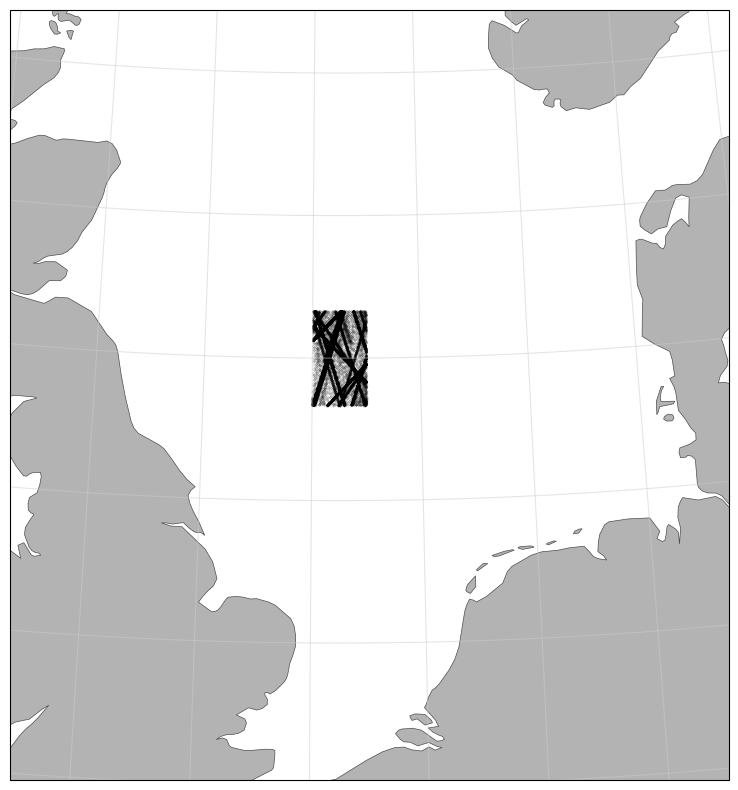

In [16]:
projection = ccrs.TransverseMercator(central_longitude=(bbox[0]+bbox[2])/2)
transform = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=projection))
ax.plot(df.longitude, df.latitude, "ok", markersize=0.2, alpha=0.3, transform=transform)
ax.set_extent([-3, 9, 51, 59], crs=transform)
ax.add_feature(cfeature.LAND.with_scale("50m"), facecolor="0.7", edgecolor="0.3", linewidth=0.5)
gl = ax.gridlines(draw_labels=False, color="0.8", alpha=0.5)

### 3.4. Plot timeseries

In [17]:
dfsort = df.set_index("time").sort_index()

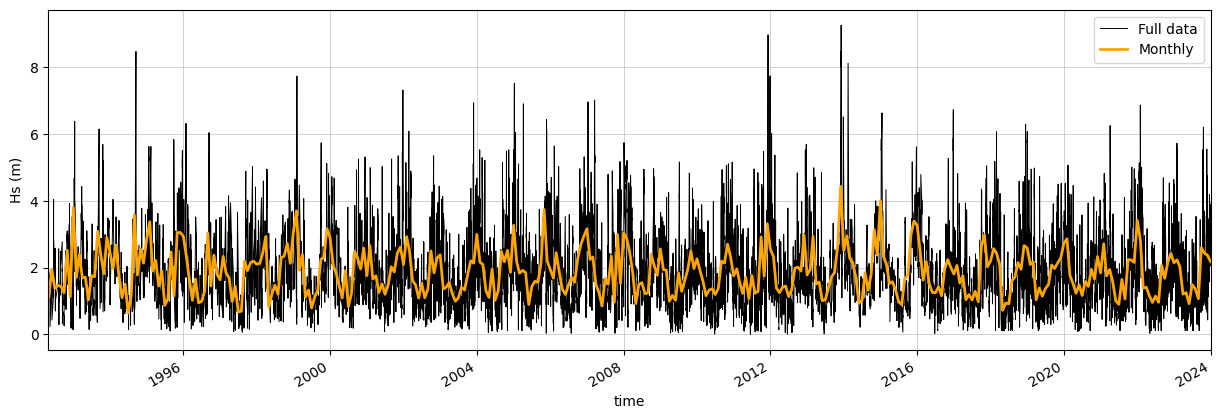

In [18]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(dfsort.index, dfsort.swh_ku_cal, "black", linewidth=0.7, label="Full data")
dfsort.swh_ku_cal.resample("MS").mean().plot(ax=ax, color="orange", linewidth=2, label="Monthly")
ax.legend()
ax.grid(color="0.5", linewidth=0.5, alpha=0.5)
ax.set_ylabel("Hs (m)")
xl = ax.set_xlim(dfsort.index.values[[0, -1]])

### 3.5. Calculate stats

#### Overall stats

In [19]:
dfsort[["swh_ku_cal"]].describe()

swh_ku_cal
count  44096.000000
mean       1.852040
std        1.092103
min        0.002000
25%        1.048000
50%        1.648000
75%        2.393250
max        9.264001

#### Mean seasonal stats

In [20]:
dfseason = dfsort.to_xarray().groupby("time.season").mean().to_pandas()
dfseason[["swh_ku_cal"]]

swh_ku_cal
season            
DJF       2.407166
JJA       1.270848
MAM       1.615850
SON       2.094952

## 4. Validate a hindcast model

Colocate and compare altimetry data within a 1-degree square with timeseries from the Oceanum Western Europe wave hindcast

### 4.1. Inspect the hindcast data in datamesh

In [21]:
cat = datamesh.get_catalog("weuro hindcast era5")
list(cat)

[
         Oceanum Western Europe ERA5 wave hindcast spectra [oceanum_wave_weuro_era5_v1_spec]
             Extent: (-10.800000190734863, 48.54999923706055, 12.899999618530273, 60.95000076293945)
             Timerange: 1979-02-01 00:00:00+00:00 to 2024-07-01 00:00:00+00:00
         ,
 
         Oceanum Western Europe ERA5 wave hindcast parameters [oceanum_wave_weuro_era5_v1_grid]
             Extent: (-11.0, 48.5, 13.0, 61.0)
             Timerange: 1979-02-01 00:00:00+00:00 to 2024-07-01 00:00:00+00:00
         ,
 
         gridded wave stats oceanum Western Europe 5km [oceanum_wave_weuro_era5_v1_gridstats]
             Extent: (-11.0, 48.5, 13.0, 61.0)
             Timerange: 1970-01-01 00:00:00+00:00 to 2024-06-24 01:42:35.888629+00:00
         ]

In [22]:
ds = datamesh.get_datasource("oceanum_wave_weuro_era5_v1_grid")

In [23]:
ds.description

'Oceanum SWAN Western Europe 5km wave hindcast forced with ERA5, gridded parameters'

In [24]:
ds.tstart

datetime.datetime(1979, 2, 1, 0, 0, tzinfo=TzInfo(UTC))

In [25]:
ds.tend

datetime.datetime(2024, 7, 1, 0, 0, tzinfo=TzInfo(UTC))

In [26]:
list(ds.variables.keys())

['hs',
 'qb',
 'dpm',
 'tps',
 'botl',
 'dspr',
 'fspr',
 'hsea',
 'hswe',
 'phs0',
 'phs1',
 'phs2',
 'phs3',
 'ptp0',
 'ptp1',
 'ptp2',
 'ptp3',
 'tm01',
 'tm02',
 'xwnd',
 'ywnd',
 'depth',
 'pdir0',
 'pdir1',
 'pdir2',
 'pdir3',
 'dpmsea',
 'dpmswe',
 'pdspr0',
 'pdspr1',
 'pdspr2',
 'pdspr3',
 'pwlen0',
 'pwlen1',
 'pwlen2',
 'pwlen3',
 'tpssea',
 'tpsswe']

### 4.2. Get the hindcast data

Load timeseries of hindcast Hs data at the central location of the satellite bounding box

In [27]:
lon = (bbox[0] + bbox[2]) / 2
lat = (bbox[1] + bbox[3]) / 2
t0, t1 = dfsort.index[[0, -1]]

query = {
    "datasource": "oceanum_wave_weuro_era5_v1_grid",
    "variables": ["hs"],
    "timefilter": {"type": "range", "times": [t0, t1]},
    "geofilter": {
        "type": "feature",
        "geom": {
            "type": "Feature",
            "geometry": {
                "type": "MultiPoint",
                "coordinates": [[lon, lat]],
            },
        },
    },
}
hds = datamesh.query(query).squeeze()
hds

<xarray.Dataset> Size: 1MB
Dimensions:      (time: 92584)
Coordinates:
  * time         (time) datetime64[ns] 741kB 1992-04-25T12:00:00 ... 2024-01-...
    spatial_ref  int64 8B 0
    longitude    float64 8B 2.5
    latitude     float64 8B 55.5
Data variables:
    hs           (time) float64 741kB 1.498 1.427 1.402 ... 2.214 2.12 2.005
Attributes:
    Conventions:             CF-1.5
    Directional_convention:  nautical
    History:                 Created with agioncmd version 1.5
    Institution:             Oceanum Ltd
    model:                   41.31A
    project:                 West Europe
    run:                     weur
    xinterp_method:          linear
    _coordinates:            {"t":"time","x":"longitude","y":"latitude"}
    _request_size:           1481368
    _domain_size:            92584
    _flattened_domain_size:  92584

### 4.3. Colocate the data

Interpolate the hindcast data at the satellite times and merge

In [28]:
df_sat = dfsort.copy()
df_hds = hds.interp(time=df_sat.index).to_pandas()
df_all = pd.concat([df_sat.platform, df_sat.swh_ku_cal, df_hds.hs], axis=1)
df_all.columns = ["platform", "satellite", "hindcast"]
df_all.head()

platform  satellite  hindcast
time                                                             
1992-04-25 11:08:10.843750  ERS-1                 0.842       NaN
1992-04-25 11:08:11.820308  ERS-1                 1.262       NaN
1992-04-25 11:08:12.804683  ERS-1                 1.495       NaN
1992-04-25 11:08:13.781251  ERS-1                 0.888       NaN
1992-04-25 11:08:14.765625  ERS-1                 1.133       NaN

### 4.3. Plot timeseries of colocations

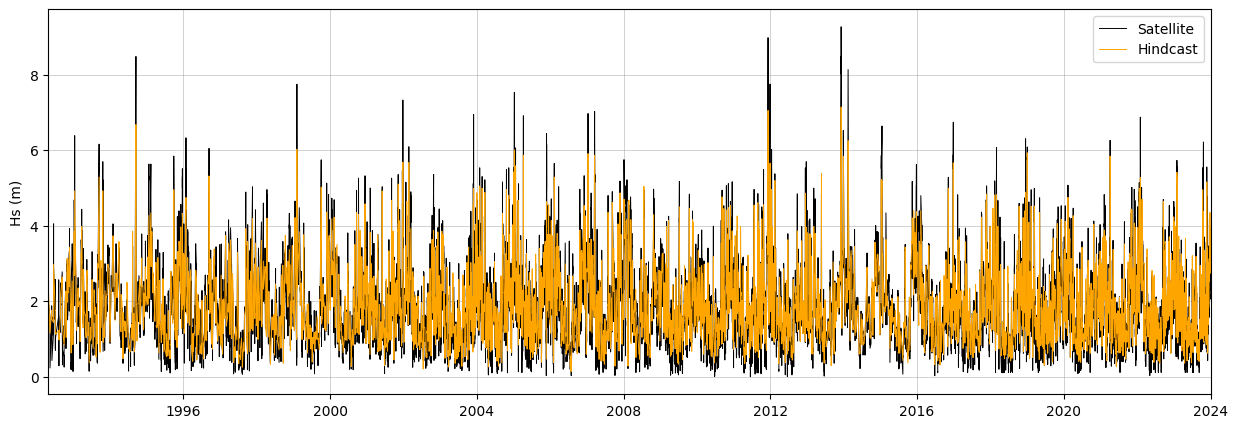

In [29]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df_all.index, df_all.satellite, "black", linewidth=0.7, label="Satellite")
ax.plot(df_all.index, df_all.hindcast, "orange", linewidth=0.7, label="Hindcast")
ax.legend()
ax.grid(color="0.5", linewidth=0.5, alpha=0.5)
ax.set_ylabel("Hs (m)")
xl = ax.set_xlim(dfsort.index.values[[0, -1]])

### 4.5. Plot scatter of colocations

Calculate error measures and show with scatter of satellite vs hindcast

In [30]:
def nsamp(df: pd.DataFrame):
    """Number of colocations."""
    return df.dropna().shape[0]


def mad(df: pd.DataFrame, x: str = "hs_obs", y: str = "hs_hds"):
    """Mean absolute difference MAD."""
    return (df[y] - df[x]).abs().mean()


def rmsd(df: pd.DataFrame, x: str = "hs_obs", y: str = "hs_hds"):
    """Root-mean-square difference RMSD."""
    return np.sqrt(((df[y] - df[x])**2).mean())


def bias(df: pd.DataFrame, x: str = "hs_obs", y: str = "hs_hds"):
    """Bias."""
    return (df[y] - df[x]).mean()


def si(df: pd.DataFrame, x: str = "hs_obs", y: str = "hs_hds"):
    """Scatter Index."""
    return np.sqrt((((df[y] - df[x]) - bias(df, x, y))**2).mean() ) / df[x].mean()


def errors(df, x: str = "hs_obs", y: str = "hs_hds"):
    """Return a label with error summary for plotting."""
    return f"Bias: {bias(df, x, y):0.2f} m\nMAD: {mad(df, x, y):0.2f} m\nRMSD: {rmsd(df, x, y):0.2f} m\nSI: {si(df, x, y):0.2f}\nN: {nsamp(df):0.0f}"

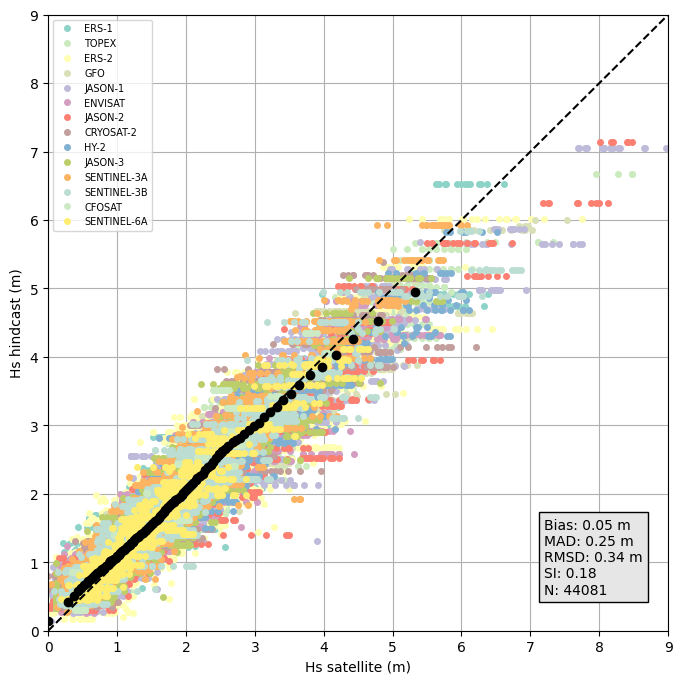

In [31]:
fig, ax = plt.subplots(figsize=(8, 8))

x = "satellite"
y = "hindcast"

xlim = ylim = [0, 9]

# Plot the data from each satellite mission
platforms = df_all.platform.str.strip()
colors = ['#8dd3c7', '#cbebbf', '#ffffb3', '#d9e0b7', '#bebada', '#d39ec0', '#fb8072', '#c29e9c', '#80b1d3', '#bcce6a', '#fdb462', '#bcded2', '#ccebc5', '#ffed6f']
for ind, platform in enumerate(platforms.unique()):
    dfp = df_all.loc[platforms==platform]
    ax.plot(dfp[x], dfp[y], "o", linestyle="none", color=colors[ind], markersize=4, label=platform)

# Plot the quantiles
dfq = df_all[[x, y]].quantile(q=np.arange(0, 1.01, 0.01))
ax.plot(dfq[x], dfq[y], "ok")

ax.annotate(errors(df_all, x, y), xy=(0.80, 0.06), xycoords="axes fraction", fontsize=10, color="0.0", bbox=dict(facecolor="0.9"))

# Axis settings
ax.plot(xlim, ylim, "--k")
ax.legend(fontsize=7)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel(f"Hs {x} (m)")
ax.set_ylabel(f"Hs {y} (m)")
ax.grid()